In [39]:
%reset -f

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

# from utils.NNSIF_model import get_prediction_model, get_trainable_model, layer_output, fluxes_SIF_predict
from utils.preprocess import include_predictions, div_daynight# , standard_x, split_train_test
from utils.plot import GPP_SIF_dependence # regression_line, 


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2


plt.rcParams["legend.frameon"] = False
plt.rcParams['savefig.dpi'] = 310
plt.rcParams['font.size'] = 13

2025-04-07 17:10:43.045209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. import & preprocess the data

In [2]:
data_NN = pd.read_csv('../input_data/in_situ_dataset_Harvard_Forest.csv',index_col=0,parse_dates=True)

In [3]:
data_NN.head()

,NEE_obs,SIF_obs,Tair,SWC,RH,PAR,LAI,wind_speed,wind_direction,PAR_label,NEE_night
2013-06-19 00:00:00,2.37,0.0,12.6,0.6190,94.5,0.0,2.45,1.4,339.0,0,3.524444
2013-06-19 01:00:00,10.95,0.0,12.3,0.6190,95.7,0.0,2.45,1.5,344.0,0,3.524444
2013-06-19 02:00:00,4.16,0.0,11.9,0.6190,93.8,0.0,2.45,2.0,353.0,0,3.524444
2013-06-19 03:00:00,5.25,0.0,11.3,0.6185,92.1,0.0,2.45,2.3,337.0,0,3.524444
2013-06-19 04:00:00,2.32,0.0,11.2,0.6180,88.1,0.0,2.45,3.0,342.0,0,3.524444


devide into training & test sets

In [4]:
train, test          = train_test_split(data_NN, test_size=0.3, random_state=31,shuffle=True)
train['train_label'] = 'Training set'
test['train_label']  = 'Test set'


select model inputs, model outputs

In [5]:
inputs_GPP  = ['Tair','RH','SWC','PAR','wind_speed','LAI'] # inputs for GPP
inputs_ER   = ['Tair','SWC','wind_speed','LAI']            # inputs for ER
inputs_SIF  = ['Tair','RH','SWC']                          # inputs for SIF
input_label = 'PAR_label'                                 # the label input used for GPP prediction

input_GPP_train = train[inputs_GPP].astype('float32')
input_ER_train  = train[inputs_ER].astype('float32')
input_SIF_train = train[inputs_SIF].astype('float32')
label_train     = train[input_label].astype('float32').values

input_GPP_test = test[inputs_GPP].astype('float32')
input_ER_test  = test[inputs_ER].astype('float32')
input_SIF_test = test[inputs_SIF].astype('float32')
label_test     = test[input_label].astype('float32').values

In [6]:
NEE_train = train['NEE_obs'].astype('float32')
SIF_train = train['SIF_obs'].astype('float32')

NEE_test = test['NEE_obs'].astype('float32')
SIF_test = test['SIF_obs'].astype('float32')

standardization for model inputs

In [7]:
def standard_x(x_train,x_test=None):
    
    '''
    This is for input standardization: X' = X - mean(X)/std(X)
    '''
    
    # the mean and std values are only calculated by training set
    x_mean   = x_train.mean(axis=0) 
    x_std    = x_train.std(axis=0)
    x_train1 = ((x_train-x_mean)/x_std).values
    
    if x_test is not None:
        x_test1  = ((x_test -x_mean)/x_std).values
        return x_train1, x_test1
    
    return x_train1 

In [8]:
input_GPP_train,input_GPP_test = standard_x(input_GPP_train,input_GPP_test)
input_ER_train, input_ER_test  = standard_x(input_ER_train, input_ER_test)
input_SIF_train,input_SIF_test = standard_x(input_SIF_train,input_SIF_test)

standardization for model outputs

In [9]:
NEE_abs_max    = (np.abs(NEE_train.values)).max()
NEE_train_norm = NEE_train.values/NEE_abs_max

SIF_abs_max    = (np.abs(SIF_train.values)).max()
SIF_train_norm = SIF_train.values/SIF_abs_max

### 2. train the $NN_{SIF}$ model

In [10]:
def get_prediction_model(n_neuron,input_GPP_shape,input_ER_shape,input_SIF_shape,
                         SIF_act=None,SIF_log=False):
    
    '''
    This is to define the structure of the NN_SIF model
    
    Parameters
    ---------- 
    n_neuron:     the number of neurons for each hidden layer
    input_GPP_shape: the shape of the input layer for GPP
    input_ER_shape: the shape of the input layer for ER
    input_SIF_shape: the shape of the input layer for SIF
    SIF_act:      the activation function for the SIF prediction
    SIF_log:      whether to use a logarithm function for the SIF prediction
    
    Returns:
    ----------
    model: the defined NN_SIF model
    
    '''
    
    # GPP
    PAR_label    = Input(shape=(1,), dtype='float32', name='PAR_label')
    input_GPP    = Input(shape=(input_GPP_shape,), dtype='float32', name='input_GPP')
    x            = Dense(n_neuron, activation='relu',name='hidden1_1')(input_GPP)
    x            = Dense(n_neuron, activation='relu',name='hidden1_2')(x)
    ln_GPP       = Dense(1, activation = None, name='ln_GPP')(x)
    GPP_original = Lambda(lambda x: K.exp(x), name='GPP_original')(ln_GPP)
    GPP          = keras.layers.Multiply(name='GPP')([GPP_original,PAR_label])

    # ER
    input_ER  = Input(shape=(input_ER_shape,), dtype='float32', name='input_ER')
    x         = Dense(n_neuron, activation='relu',name='hidden2_1')(input_ER) 
    x         = Dense(n_neuron, activation='relu',name='hidden2_2')(x) 
    ln_ER     = Dense(1,  activation=None,name='ln_ER')(x)
    ER      = Lambda(lambda x: K.exp(x),name='ER')(ln_ER)

    NEE       = keras.layers.Subtract(name='NEE')([ER, GPP])
    
    # SIF = f(GPP,other environmental variables)
    input_SIF = Input(shape=(input_SIF_shape,), dtype='float32', name='input_SIF')
    combined  = keras.layers.Concatenate(name='combined')([GPP, input_SIF])
    x         = Dense(n_neuron, activation='relu',name='hidden3_1')(combined)
    x         = Dense(n_neuron, activation='relu',name='hidden3_2')(x)
    if SIF_log:
        ln_SIF    = Dense(1,  activation=None,name='ln_SIF')(x)
        SIF       = Lambda(lambda x: K.exp(x),name='SIF')(ln_SIF)
    else:
        SIF       = Dense(1, name='SIF',activation=SIF_act)(x)
    
    model = Model(inputs=[PAR_label,input_GPP,input_ER,input_SIF], outputs=[NEE,SIF])


    return model


In [11]:
# Custom loss layer
# reference: https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example.ipynb
class CustomMultiLossLayer(Layer):
    
    '''
    This is to achieve the multi-task learning
    '''
    
    def __init__(self, nb_logvars=2,nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs # number of outputs
        self.nb_logvars = nb_logvars # number of log_vars
        self.is_placeholder = True
        self.mse_nee = tf.keras.metrics.Mean(name='mse_nee')
        self.mse_sif = tf.keras.metrics.Mean(name='mse_sif')
        super(CustomMultiLossLayer, self).__init__(**kwargs)
    
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_logvars):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(CustomMultiLossLayer, self).build(input_shape)


    def multi_loss(self, NEE_true,SIF_true,NEE_pred,SIF_pred):
        loss = 0
        if self.nb_logvars == 2:
            log_var1, log_var2 = self.log_vars
            precision_NEE = K.exp(-log_var1)
            precision_SIF = K.exp(-log_var2)
            
            loss = K.sum(precision_NEE * (NEE_true - NEE_pred)**2. + log_var1, -1) + \
                   K.sum(precision_SIF * (SIF_true - SIF_pred)**2. + log_var2, -1) 
              
        return K.mean(loss) 

    def call(self, inputs):
        # metrics: MSE of NEE & SIF
        NEE_true, SIF_true  = inputs[:self.nb_outputs] 
        NEE_pred, SIF_pred  = inputs[self.nb_outputs:2*self.nb_outputs]
        APAR_input = inputs[-1]
        
        MSE_NEE = self.mse_nee(tf.square(NEE_pred-NEE_true)) # tf.square(NEE_pred-NEE_true)
        MSE_SIF = self.mse_sif(K.mean(K.square(SIF_pred*APAR_input-SIF_true)))
        
        self.add_metric(MSE_NEE)
        self.add_metric(MSE_SIF) 
        
        
        if self.nb_logvars ==2:
            loss    = self.multi_loss(NEE_true,SIF_true,NEE_pred,SIF_pred)
        
        self.add_loss(loss, inputs=inputs)
        
        return K.concatenate(inputs, -1)

In [12]:
def get_trainable_model(prediction_model,input_GPP_shape,input_ER_shape,input_SIF_shape):
    
    '''
    This is to implement the multi-task training for NN_SIF: the weights of NEE & SIF are inferred purely from data
    
    Parameters
    ---------- 
    prediction_model: the defined structure of NN_SIF (the returned variable of the 'get_prediction_model' function)
    input_GPP_shape: the shape of the input layer for GPP
    input_ER_shape: the shape of the input layer for ER
    input_SIF_shape: the shape of the input layer for SIF
    
    Returns:
    ----------
    model: the NN_SIF model to be trained
    
    '''
    
    PAR_label = Input(shape=(1,), dtype='float32', name='PAR_label')
    input_GPP  = Input(shape=(input_GPP_shape,), dtype='float32', name='input_GPP')
    input_ER   = Input(shape=(input_ER_shape,), dtype='float32', name='input_ER')
    input_SIF  = Input(shape=(input_SIF_shape,), dtype='float32', name='input_SIF')
    
    NEE_pred,SIF_pred = prediction_model([PAR_label,input_GPP,input_ER,input_SIF])
    
    NEE_truth = Input(shape=(1,), name='NEE_truth')
    SIF_truth = Input(shape=(1,), name='SIF_truth')
    
    out      = CustomMultiLossLayer(nb_outputs=2)([NEE_truth,SIF_truth,NEE_pred,SIF_pred,PAR_label])
    
    return Model([PAR_label,input_GPP,input_ER,input_SIF,NEE_truth,SIF_truth], out)



In [13]:


# define model structure
prediction_model = get_prediction_model(n_neuron=64,
                                        input_GPP_shape=input_GPP_train.shape[1],
                                        input_ER_shape =input_ER_train.shape[1],
                                        input_SIF_shape=input_SIF_train.shape[1])

# define the model to be trained
trainable_model  = get_trainable_model(prediction_model,
                                       input_GPP_shape=input_GPP_train.shape[1],
                                       input_ER_shape =input_ER_train.shape[1],
                                       input_SIF_shape=input_SIF_train.shape[1])

trainable_model.compile(optimizer=keras.optimizers.legacy.Adam(lr=0.002), 
                        loss=None)

assert len(trainable_model.layers[-1].trainable_weights) == 2  
assert len(trainable_model.losses) == 1


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = trainable_model.fit([label_train, input_GPP_train, input_ER_train, input_SIF_train,
                            NEE_train_norm, SIF_train_norm], 
                           epochs=60, batch_size=64, verbose=1, validation_split=0.3,
                           callbacks=[early_stopping])

Train on 3564 samples, validate on 1528 samples


2025-04-07 17:11:45.512740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 17:11:45.546282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2025-04-07 17:11:45.604829: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/SIF/bias/v/Assign' id:808 op device:{requested: '', assigned: ''} def:{{{node training/Adam/SIF/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/SIF/bias/v, training/Adam/SIF/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the futur

Epoch 1/60
3564/3564 [==============================] - 0s 94us/sample - loss: 0.0529 - mse_nee: 0.1289 - mse_sif: 0.0095 - val_loss: -0.1930 - val_mse_nee: 0.0145 - val_mse_sif: 0.0061
Epoch 2/60
3564/3564 [==============================] - 0s 28us/sample - loss: -0.3063 - mse_nee: 0.0138 - mse_sif: 0.0053 - val_loss: -0.4248 - val_mse_nee: 0.0128 - val_mse_sif: 0.0048
Epoch 3/60


2025-04-07 17:11:45.971128: W tensorflow/c/c_api.cc:291] Operation '{name:'custom_multi_loss_layer/Mean_1' id:367 op device:{requested: '', assigned: ''} def:{{{node custom_multi_loss_layer/Mean_1}} = Mean[T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true, keep_dims=false](custom_multi_loss_layer/add_2, custom_multi_loss_layer/Const_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


3564/3564 [==============================] - 0s 28us/sample - loss: -0.5358 - mse_nee: 0.0122 - mse_sif: 0.0045 - val_loss: -0.6512 - val_mse_nee: 0.0118 - val_mse_sif: 0.0048
Epoch 4/60
3564/3564 [==============================] - 0s 28us/sample - loss: -0.7621 - mse_nee: 0.0112 - mse_sif: 0.0042 - val_loss: -0.8758 - val_mse_nee: 0.0116 - val_mse_sif: 0.0043
Epoch 5/60
3564/3564 [==============================] - 0s 28us/sample - loss: -0.9857 - mse_nee: 0.0110 - mse_sif: 0.0042 - val_loss: -1.0994 - val_mse_nee: 0.0111 - val_mse_sif: 0.0043
Epoch 6/60
3564/3564 [==============================] - 0s 27us/sample - loss: -1.2098 - mse_nee: 0.0104 - mse_sif: 0.0039 - val_loss: -1.3221 - val_mse_nee: 0.0112 - val_mse_sif: 0.0038
Epoch 7/60
3564/3564 [==============================] - 0s 28us/sample - loss: -1.4321 - mse_nee: 0.0103 - mse_sif: 0.0036 - val_loss: -1.5418 - val_mse_nee: 0.0119 - val_mse_sif: 0.0038
Epoch 8/60
3564/3564 [==============================] - 0s 28us/sample - los

### 3. predict carbon fluxes using the well-trained model

In [14]:
def get_layer_output(model,layer_name, PAR_label,input_GPP,input_ER,input_SIF):
    
    '''
    To retrieve the output predicted by a specified NN layer
    
    Parameters
    ---------- 
    model:      the well-trained model
    layer_name: the layer of which output we want to obtain  
    PAR_label:  the 'PAR_label' input 
    input_GPP: the input data for GPP estimation
    input_ER: the input data for ER estimation
    input_SIF: the input data for the estimation of the GPP-SIF relationship
    
    Returns:
    ---------- 
    layer_output: the prediction of the specifed layer
    
    '''
    
    layer_model  = Model(inputs =model.input,
                         outputs=model.get_layer(layer_name).output)
    layer_output = layer_model.predict({'PAR_label':  PAR_label,
                                        'input_GPP':  input_GPP,
                                        'input_ER':   input_ER,
                                        'input_SIF':  input_SIF})
    return layer_output


In [15]:
def fluxes_SIF_predict(model,PAR_label,input_GPP, input_ER, input_SIF, 
                       NEE_abs_max, SIF_abs_max):
    
    '''
    To predict GPP, ER & SIF using the well-trained NN_SIF model
    
    Parameters
    ----------
    model:      the well-trained NN_SIF model
    PAR_label:  the 'PAR_label' input
    input_GPP:  input data for GPP estimation
    input_ER:   input data for ER estimation
    input_SIF:  input data for the estimation of the GPP-SIF relationship
    NEE_max_abs: the max value of abs(NEE), which is used to convert back to the real value of NEE
    SIF_max_abs: the max value of abs(SIF), which is used to convert back to the real value of SIF
    
    Returns:
    ---------- 
    NEE_NN:  the NN-predicted NEE 
    GPP_NN:  the NN-predicted GPP 
    ER_NN:   the NN-predicted ER
    SIF_NN:  the NN-predicted SIF
    '''
    
    NEE_NN  = (get_layer_output(model,'NEE',PAR_label,input_GPP,input_ER,input_SIF) * NEE_abs_max)
    NEE_NN  = NEE_NN.reshape(NEE_NN.shape[0],)
    
    GPP_NN  = (get_layer_output(model,'GPP',PAR_label,input_GPP,input_ER,input_SIF) * NEE_abs_max).reshape(NEE_NN.shape[0],)
    ER_NN   = (get_layer_output(model,'ER', PAR_label,input_GPP,input_ER,input_SIF) * NEE_abs_max).reshape(NEE_NN.shape[0],)
    SIF_NN  = (get_layer_output(model,'SIF',PAR_label,input_GPP,input_ER,input_SIF) * SIF_abs_max).reshape(NEE_NN.shape[0],)
    

    return NEE_NN, GPP_NN, ER_NN, SIF_NN

In [16]:
NEE_trainNN, GPP_trainNN, Reco_trainNN, SIF_trainNN = fluxes_SIF_predict(prediction_model,label_train,
                                                                         input_GPP_train, input_ER_train, input_SIF_train,
                                                                         NEE_abs_max, SIF_abs_max)
NEE_testNN, GPP_testNN, Reco_testNN, SIF_testNN = fluxes_SIF_predict(prediction_model,label_test,
                                                                     input_GPP_test, input_ER_test, input_SIF_test,
                                                                     NEE_abs_max, SIF_abs_max)



train = include_predictions(train,NEE_trainNN, GPP_trainNN, Reco_trainNN, SIF_trainNN)
test  = include_predictions(test,NEE_testNN, GPP_testNN, Reco_testNN, SIF_testNN)

# save the data
data_NN = pd.concat([train,test],axis=0).sort_index()
day_NN, night_NN = div_daynight(data_NN)

2025-04-07 17:12:35.466522: W tensorflow/c/c_api.cc:291] Operation '{name:'NEE/sub' id:150 op device:{requested: '', assigned: ''} def:{{{node NEE/sub}} = Sub[T=DT_FLOAT, _has_manual_control_dependencies=true](ER/Exp, GPP/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-04-07 17:12:35.599858: W tensorflow/c/c_api.cc:291] Operation '{name:'GPP/mul' id:76 op device:{requested: '', assigned: ''} def:{{{node GPP/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](GPP_original/Exp, PAR_label)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-04-07 17:12:35.711971: W tensorflow/c/c_api.cc:291] Operation '{name:'ER/Exp' id:149 op device:{requeste

### 4. evaluate the model partitioning

In [17]:
def plot_time_series(data, var_NN, var_obs,var_str,var_unit):

    # Identify the gap in the data
    gap_start = data.index[data.index.year == 2013][-1]
    gap_end = data.index[data.index.year == 2014][0]

    # Create the plot with a broken x-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4), gridspec_kw={'width_ratios': [5, 5.5]})

    # Plot the data before the gap
    data.loc[:gap_start, var_NN].plot(ax=ax1, label='$NN_{SIF}$ estimation', color='blue', alpha=0.7)
    if var_obs is not None:
        data.loc[:gap_start, var_obs].plot(ax=ax1, label='observation', color='orange', alpha=0.7)
    
    # Plot the data after the gap
    data.loc[gap_end:, var_NN].plot(ax=ax2, label='$NN_{SIF}$ estimation', color='blue', alpha=0.7)
    if var_obs is not None:
        data.loc[gap_end:, var_obs].plot(ax=ax2, label='observation', color='orange', alpha=0.7)
    
    # Add labels and titles
    ax1.set_xlabel('Time (2013)')
    ax2.set_xlabel('Time (2014)')
    ax1.set_ylabel(f'{var_str} ({var_unit})')

    # Add a cut indicator
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ax1.tick_params(labelright=False)
    ax2.tick_params(labelleft=False)

    # Set consistent xticks for both axes
    xticks = pd.date_range(start='2013-06-01', end='2013-11-01', freq='2M')
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([tick.strftime('%b %Y') for tick in xticks], rotation=45)

    xticks = pd.date_range(start='2014-05-01', end='2014-11-01', freq='2M')
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([tick.strftime('%b %Y') for tick in xticks], rotation=45)

    d1 = 0.015  # Size of the diagonal lines for ax1
    d2 = 0.015  # Size of the diagonal lines for ax2 (same as d1 to make them parallel)

    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1 - d1, 1 + d1), (-d1, +d1), **kwargs)  # Top-right diagonal
    ax1.plot((1 - d1, 1 + d1), (1 - d1, 1 + d1), **kwargs)  # Bottom-right diagonal

    kwargs.update(transform=ax2.transAxes)  # Switch to the second axis
    ax2.plot((-d2, +d2), (-d2, +d2), **kwargs)  # Top-left diagonal
    ax2.plot((-d2, +d2), (1 - d2, 1 + d2), **kwargs)  # Bottom-left diagonal

    # Adjust layout
    plt.tight_layout()
    plt.legend()

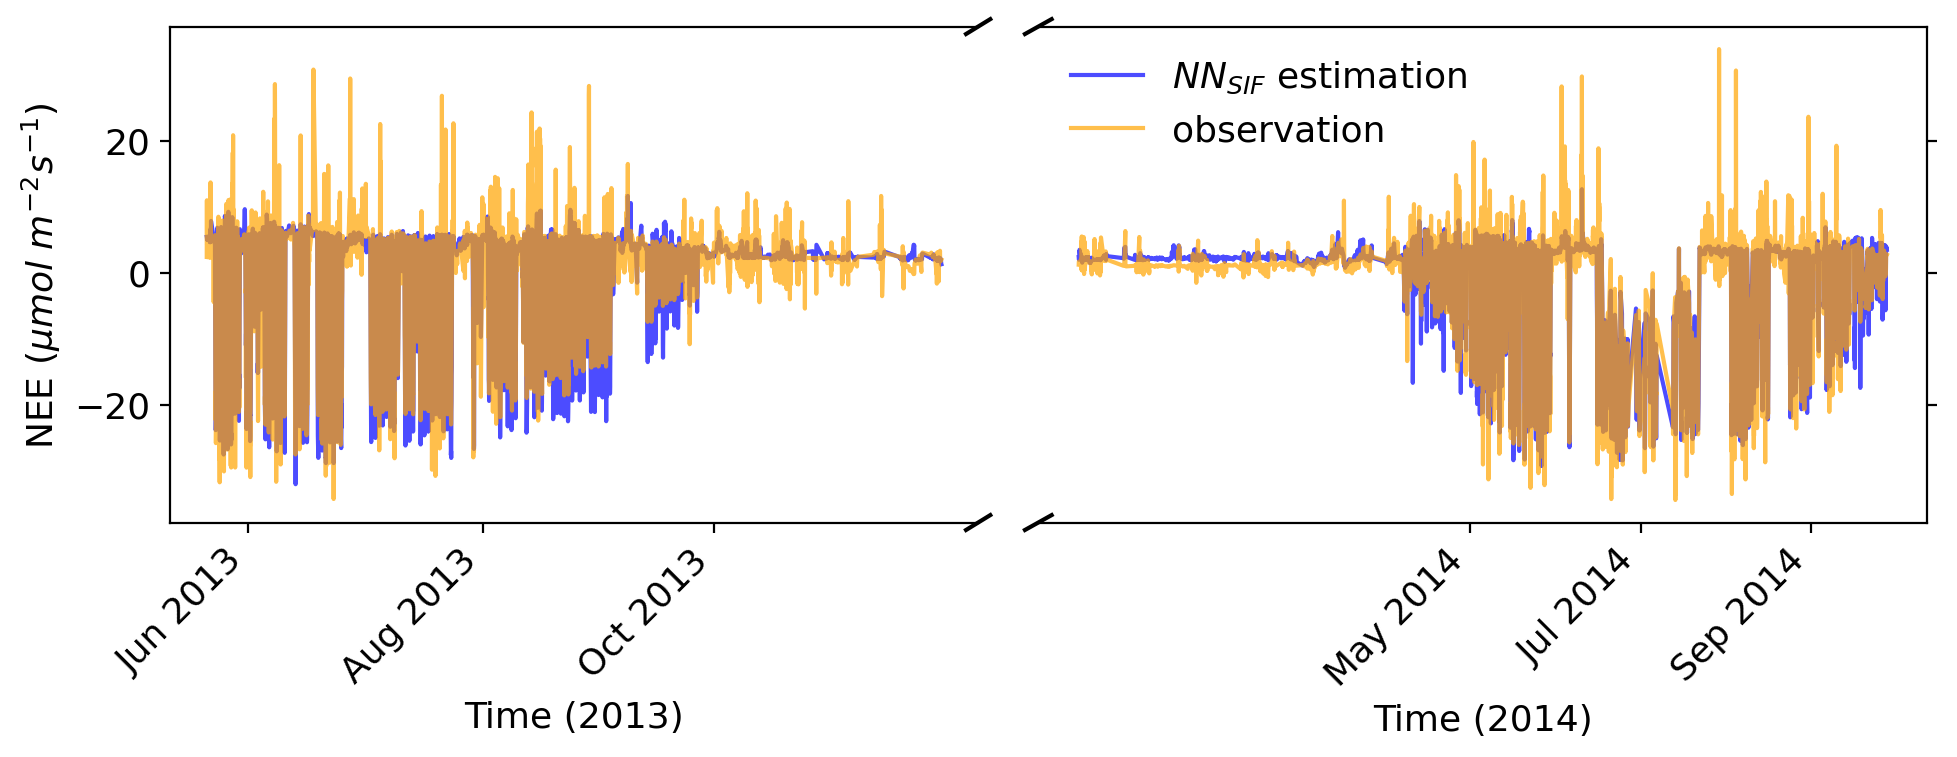

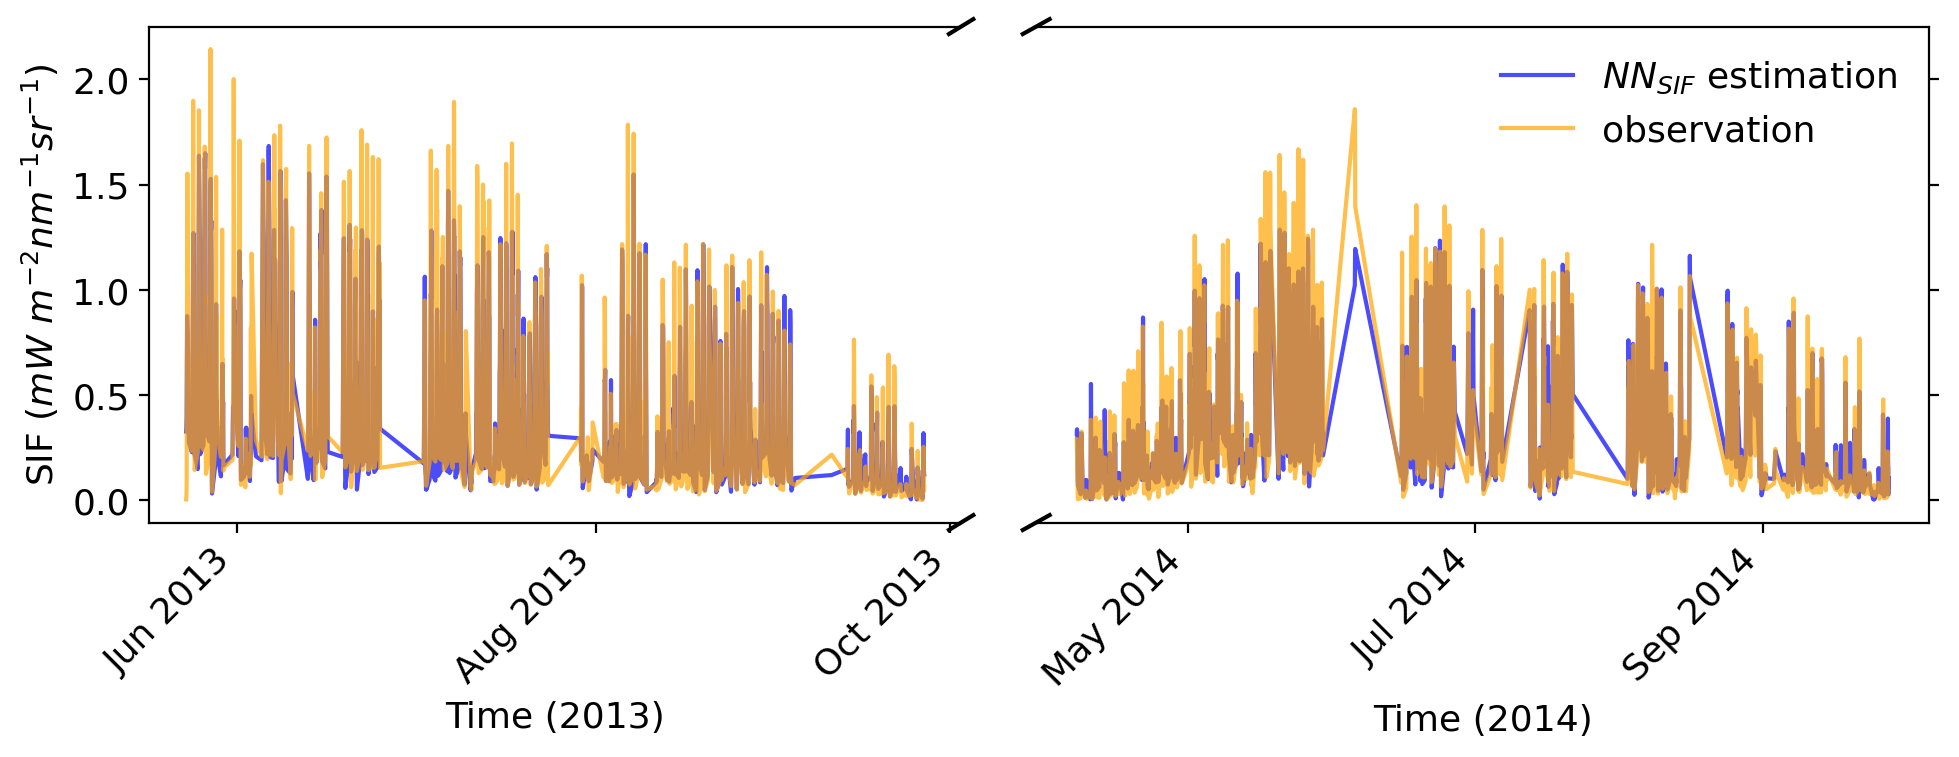

In [18]:
plot_time_series(data_NN, 'NEE_NN', 'NEE_obs','NEE','$\mu mol$ $m^{-2} s^{-1}$')
plot_time_series(day_NN, 'SIF_NN', 'SIF_obs','SIF','$mW \ m^{-2} nm^{-1} sr^{-1}$')

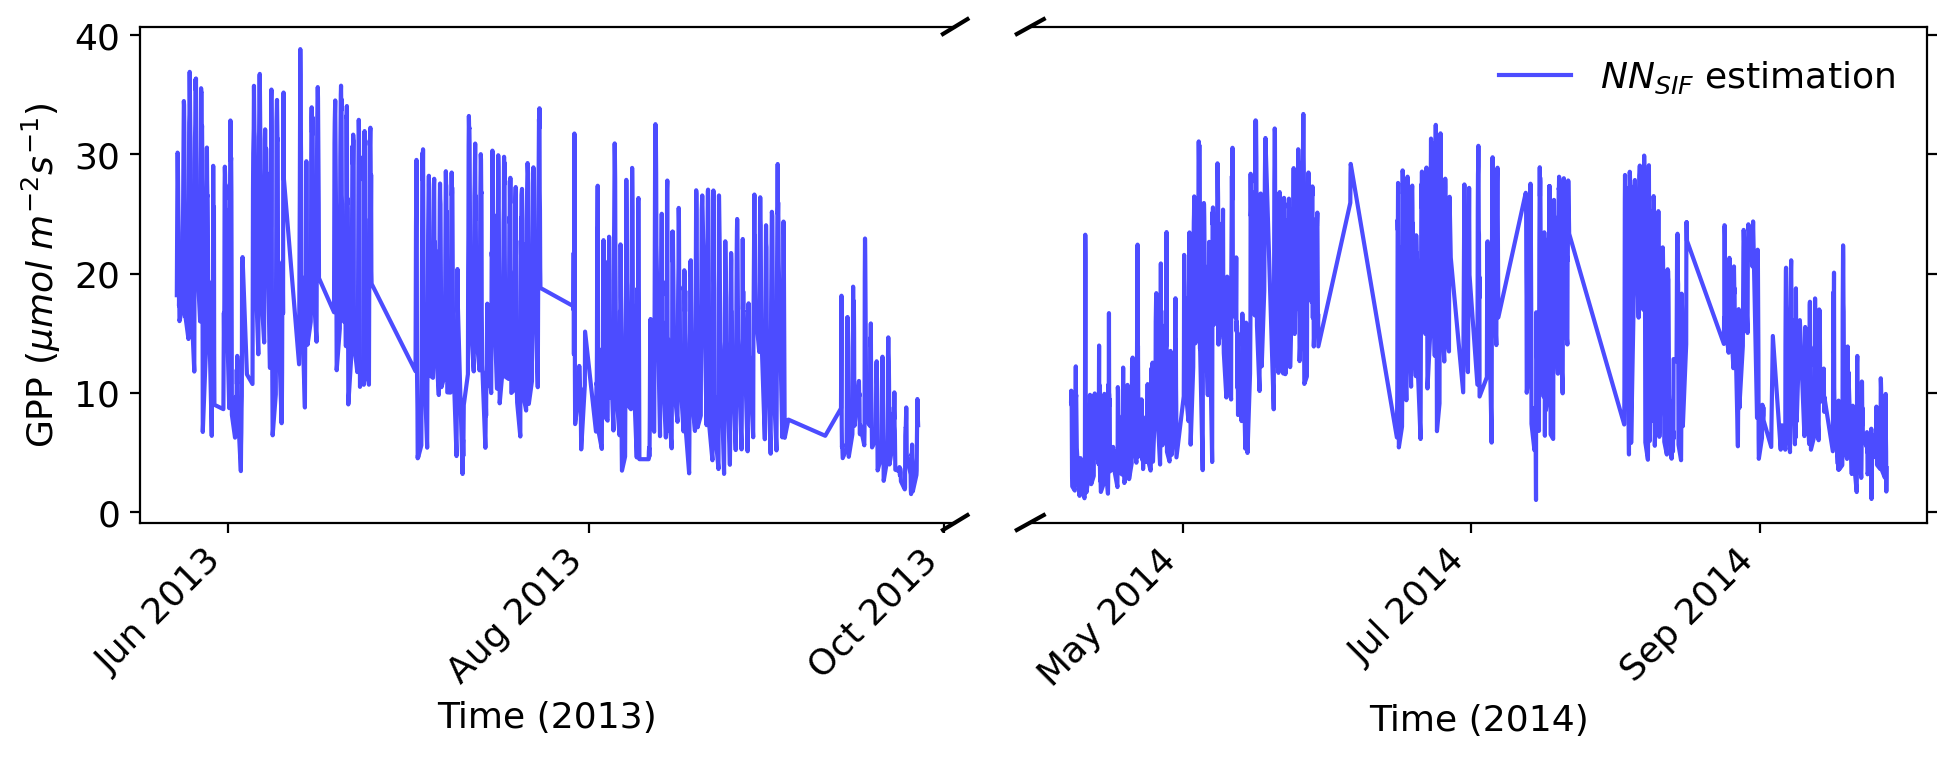

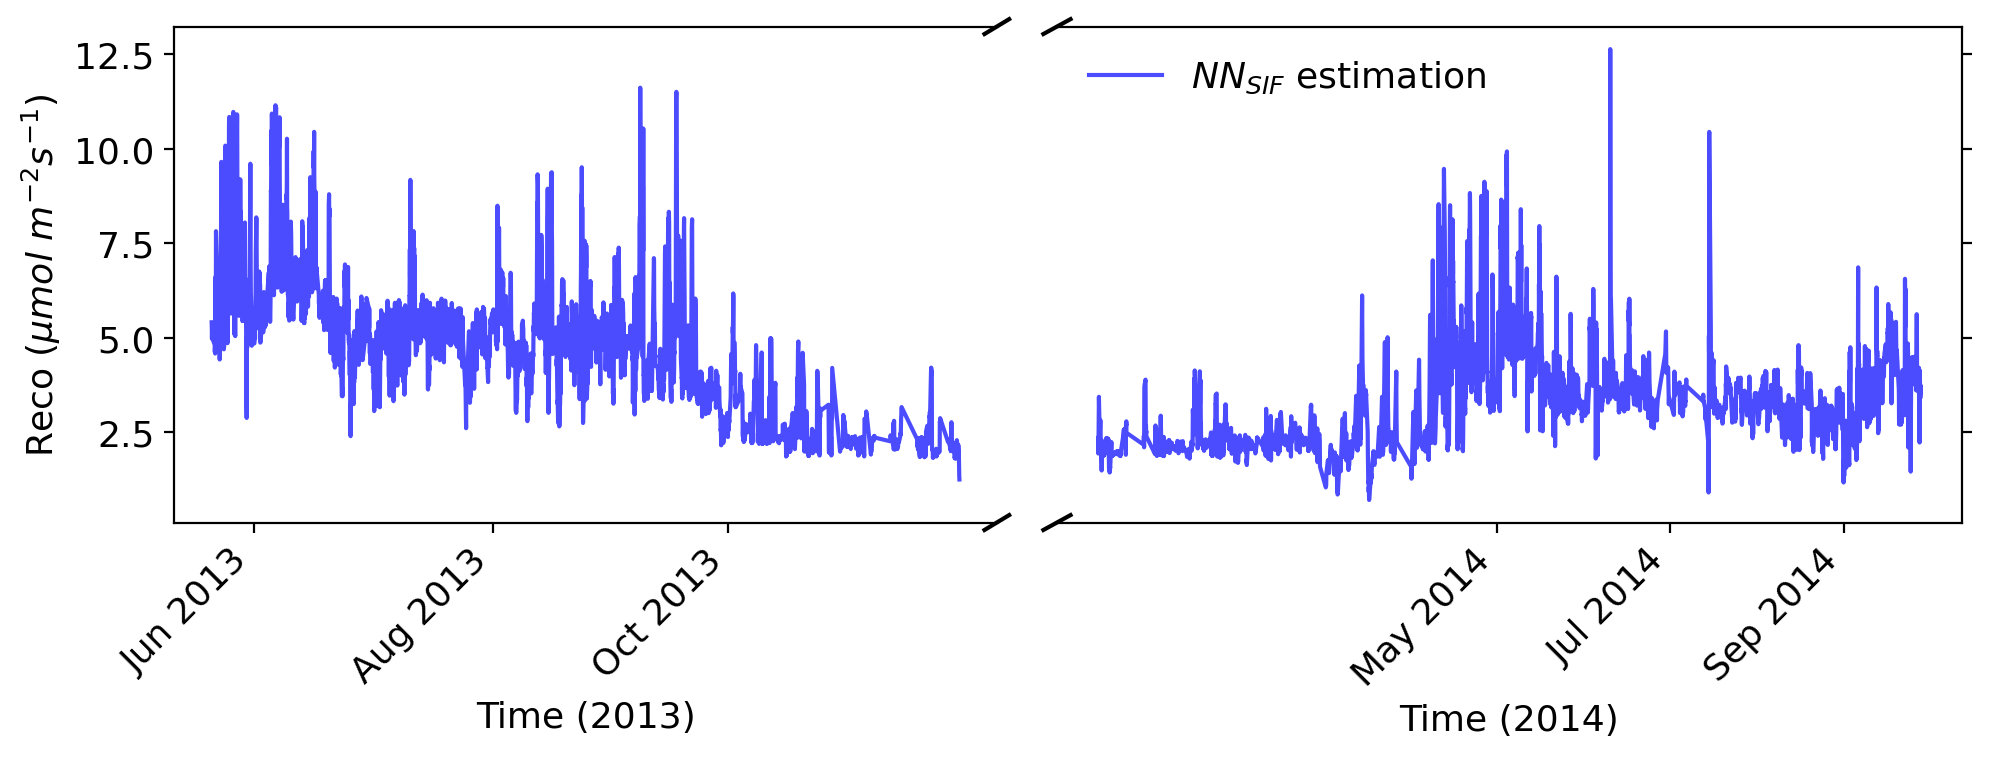

In [19]:
plot_time_series(day_NN, 'GPP_NN', None,'GPP','$\mu mol$ $m^{-2} s^{-1}$')
plot_time_series(data_NN, 'Reco_NN', None,'Reco','$\mu mol$ $m^{-2} s^{-1}$')

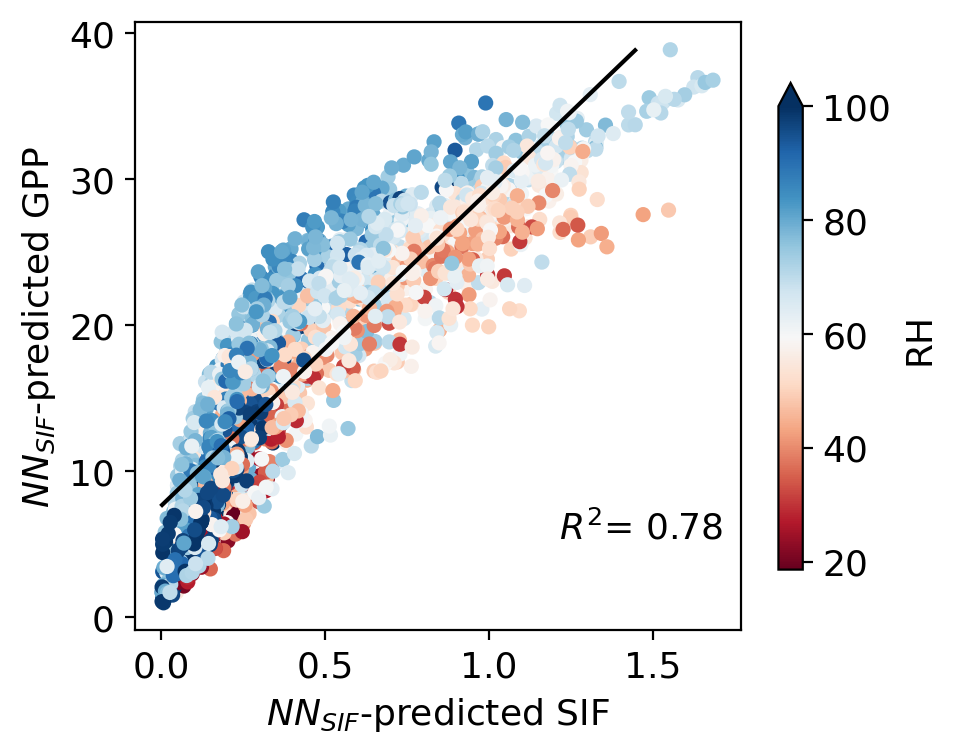

In [20]:
fig, ax = plt.subplots(figsize=(5,4))

GPP_SIF_dependence(day_NN,'SIF_NN','GPP_NN',ax,'RH','RdBu',fig,'RH',s=20) 

ax.set_xlabel('$NN_{SIF}$-predicted SIF')
ax.set_ylabel('$NN_{SIF}$-predicted GPP')

plt.tight_layout()